In [27]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import kagglehub
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

In [2]:
def process_mask(mask):
    mask = np.clip(mask, 0, NUM_CLASSES - 1)
    mask = to_categorical(mask, num_classes=NUM_CLASSES)
    return mask

def load_image_mask(image_path, mask_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    mask = load_img(mask_path, target_size=IMG_SIZE, color_mode='grayscale')
    img = img_to_array(img) / 255.0
    mask = img_to_array(mask).astype(np.int32).squeeze()
    mask = process_mask(mask)
    return img, mask

def load_dataset(image_dir, mask_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') and os.path.exists(os.path.join(mask_dir, filename.replace('.jpg', '.png'))):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            img, mask = load_image_mask(img_path, mask_path)
            images.append(img)
            masks.append(mask)
    return np.array(images), np.array(masks)

def plot_and_save(history, metric, save_path):
    plt.figure()
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.savefig(save_path)
    plt.close()

def unet_model(input_size=(128, 128, 3), num_classes=21):
    inputs = tf.keras.Input(input_size)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    bn = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    u1 = tf.keras.layers.UpSampling2D((2, 2))(bn)
    d1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    u2 = tf.keras.layers.UpSampling2D((2, 2))(d1)
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)
    model = tf.keras.Model(inputs, outputs)
    return model

def data_generator(image_files, mask_files, batch_size, img_size=(128, 128), num_classes=21):
    """
    Gera lotes de dados a partir de listas de caminhos de arquivos de imagem e máscara.
    """
    while True:
        for i in range(0, len(image_files), batch_size):
            batch_img_files = image_files[i:i + batch_size]
            batch_mask_files = mask_files[i:i + batch_size]
            images, masks = [], []
            for img_path, mask_path in zip(batch_img_files, batch_mask_files):
                img = load_img(img_path, target_size=img_size)
                mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
                img = img_to_array(img) / 255.0
                mask = img_to_array(mask).astype(np.int32).squeeze()
                mask = np.clip(mask, 0, num_classes - 1)
                mask = to_categorical(mask, num_classes=num_classes)  # Transformar em one-hot
                images.append(img)
                masks.append(mask)
            yield np.array(images), np.array(masks)

In [3]:
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")
IMAGE_DIR = os.path.join(path, 'VOC2012_train_val/VOC2012_train_val/JPEGImages/')
MASK_DIR = os.path.join(path, 'VOC2012_train_val/VOC2012_train_val/SegmentationClass/')

IMG_SIZE = (128, 128)
NUM_CLASSES = 21
BATCH_SIZE = 8
EPOCHS = 1

In [4]:
image_files = []
mask_files = []
for filename in os.listdir(IMAGE_DIR):
    if filename.endswith('.jpg') and os.path.exists(os.path.join(MASK_DIR, filename.replace('.jpg', '.png'))):
        img_path = os.path.join(IMAGE_DIR, filename)
        mask_path = os.path.join(MASK_DIR, filename.replace('.jpg', '.png'))
        image_files.append(img_path)
        mask_files.append(mask_path)

## Validação Cruzada

A validação cruzada é uma técnica essencial para avaliar o desempenho de modelos de segmentação de imagens, ajudando a garantir que o modelo não esteja superajustado (overfitting) ao conjunto de dados de treinamento. Em vez de simplesmente treinar e testar o modelo uma única vez, a validação cruzada permite testar o modelo em diferentes subconjuntos de dados, proporcionando uma análise mais robusta e confiável de sua performance.

### K-Fold Cross Validation

O método mais comum, onde o conjunto de dados é dividido em "K" partes ou "folds".
Processo:

1. Dividir os dados em K partes de tamanho igual.
2. Treinar o modelo em K-1 partes e testar na parte restante.
3. Repetir o processo K vezes, alternando a parte de teste a cada repetição.
4. Calcular a média das métricas de desempenho para obter uma avaliação geral do modelo.

# Métricas de Avaliação

A avaliação de desempenho para esses modelos de segmentação é essencial para garantir que as previsões feitas sejam precisas e consistentes com as anotações manuais (ground truth). Sem uma avaliação adequada, é difícil medir melhorias, comparar diferentes abordagens ou ajustar modelos para aplicações reais. Ela também ajuda a detectar possíveis problemas como falsos positivos (quando o modelo identifica algo que não existe) e falsos negativos (quando o modelo deixa de identificar algo que está presente).

Portanto, o processo de avaliação vai além de simplesmente observar as previsões visuais — envolve o uso de métricas quantitativas que ajudam a medir, comparar e melhorar a eficácia dos modelos de segmentação. Na próxima seção, exploraremos as métricas comuns usadas para essa análise.

## Matriz de confusão

A matriz de confusão é uma ferramenta fundamental para a avaliação de modelos de segmentação de imagens, permitindo uma análise detalhada de como o modelo está classificando cada classe de pixels. Ela mostra a distribuição de previsões corretas e incorretas feitas pelo modelo, o que facilita a identificação de padrões de erro específicos.

In [5]:
def compute_confusion_matrix(y_true, y_pred, num_classes=21):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

In [25]:
def plot_confusion_matrix(y_true, y_pred, num_classes, class_names=None):
    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Configura o gráfico
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    
    # Configurações dos eixos
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    plt.title("Confusion Matrix")
    plt.show()

 ## Métricas Comuns para Avaliação

### IoU (Intersection over Union)


Também conhecido como Jaccard Index, o IoU é uma das métricas mais populares para medir a precisão de segmentação. Ele calcula a sobreposição entre a área prevista pelo modelo e a área real (ground truth):

$$
IoU = \frac{\text{Área de interseção}}{\text{Área de união}}
$$


Valores mais altos de IoU indicam uma melhor correspondência entre a segmentação prevista e a segmentação real. O IoU é utilizado para calcular o desempenho médio de um modelo em todas as classes (mIoU - Mean IoU).

In [6]:
def compute_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        if union == 0:
            iou.append(float('nan'))
        else:
            iou.append(intersection / union)
    return np.nanmean(iou)

### Mean IoU

Mean Intersection over Union (Mean IoU) é uma média da métrica IoU calculada para cada classe. Ele mede a sobreposição entre a área prevista e a área real, considerando todas as classes e depois tirando a média.

$$ \text{IoU} = \frac{\text{Interseção}}{\text{União}} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives} + \text{False Negatives}} $$

$$ \text{mIoU} = \frac{1}{C} \sum_{i=1}^{C} \text{IoU}_i $$

### Accuracy (Precisão Geral)

Mede a proporção de pixels classificados corretamente pelo modelo em relação ao total de pixels.
É uma métrica simples, mas pode ser enganosa em datasets desbalanceados, onde uma classe é dominante (ex.: segmentar uma imagem com muito céu e poucos objetos menores).

### Recall e Precision


- **Recall (Sensibilidade):** Mede a capacidade do modelo de identificar todos os pixels de uma determinada classe. Um alto recall significa que poucos pixels reais foram deixados de fora.

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$
- **Precision (Precisão Específica):** Mede quantos dos pixels classificados como uma determinada classe são realmente dessa classe.

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

In [7]:
def compute_precision_recall(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    return precision, recall

### F1-Score

$$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

In [8]:
def compute_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

### Curvas ROC e AUC (Area Under Curve)

- Embora mais comuns em problemas de classificação binária, as curvas ROC (Receiver Operating Characteristic) também podem ser usadas para segmentação, ajudando a entender a sensibilidade do modelo a diferentes limiares de decisão.

- AUC (Área Sob a Curva) fornece uma medida da capacidade geral de separação do modelo. Valores próximos a 1 indicam bom desempenho.

In [19]:
def plot_roc_auc(y_true, y_pred, num_classes):
    if len(y_true) == 0 or len(y_pred) == 0:
        return float('nan')  # Return NaN if y_true or y_pred is empty

    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(num_classes))
    
    auc_list = []
    for i in range(num_classes):
        if y_true_bin[:, i].sum() == 0:
            continue
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
    return np.mean(auc_list) if auc_list else float('nan')


In [20]:
def plot_combined_roc_auc_kfold(y_true_folds, y_pred_folds, num_classes):
    auc_scores = []
    
    for fold_y_true, fold_y_pred in zip(y_true_folds, y_pred_folds):
        fold_auc = plot_roc_auc(fold_y_true, fold_y_pred, num_classes)
        if not np.isnan(fold_auc):
            auc_scores.append(fold_auc)
    
    # Retorna a média das AUCs das dobras
    return np.mean(auc_scores) if auc_scores else float('nan')

## Métricas Específicas para Segmentação Semântica

### Boundary F1 Score

O Boundary F1 Score mede a precisão das bordas ou contornos dos objetos segmentados. Ele é útil em aplicações onde a precisão dos contornos é crítica, como em análise médica (por exemplo, segmentação de tumores) ou visão industrial (como identificar bordas de peças).

$$ \text{Boundary Precision} = \frac{\text{Bordas Verdadeiras Positivas}}{\text{Bordas Verdadeiras Positivas} + \text{Bordas Falsas Positivas}}$$

$$ \text{Boundary Recall} = \frac{\text{Bordas Verdadeiras Positivas}}{\text{Bordas Verdadeiras Positivas} + \text{Bordas Falsas Negativas}}$$

$$\text{Boundary F1} = 2 \times \frac{\text{Boundary Precision} \times \text{Boundary Recall}}{\text{Boundary Precision} + \text{Boundary Recall}}$$

In [11]:
def compute_boundary_f1(y_true, y_pred, dilation_radius=2):
    # Aumentar o raio de dilatação pode capturar mais bordas
    from scipy.ndimage import binary_dilation
    
    # Calcular as bordas usando dilatação binária
    boundary_true = binary_dilation(y_true, iterations=dilation_radius) ^ y_true
    boundary_pred = binary_dilation(y_pred, iterations=dilation_radius) ^ y_pred

    # Calcular interseção e união
    intersection = (boundary_true & boundary_pred).sum()
    precision_boundary = intersection / boundary_pred.sum() if boundary_pred.sum() > 0 else 0
    recall_boundary = intersection / boundary_true.sum() if boundary_true.sum() > 0 else 0
    
    # Calcular Boundary F1 Score
    if precision_boundary + recall_boundary == 0:
        return 0.0
    boundary_f1 = 2 * (precision_boundary * recall_boundary) / (precision_boundary + recall_boundary)
    return boundary_f1

### Pixel Accuracy

Pixel Accuracy mede a proporção de pixels que foram corretamente classificados pelo modelo em relação ao total de pixels na imagem.

$$ \text{Pixel Accuracy} = \frac{\text{Número de Pixels Corretos}}{\text{Número Total de Pixels}} $$

In [12]:
def compute_pixel_accuracy(y_true, y_pred):
    correct = (y_true == y_pred).sum()
    total = y_true.size
    return correct / total

# Resultados

In [ ]:
import tensorflow as tf
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

In [13]:
model_save_dir = './trained_models'
os.makedirs(model_save_dir, exist_ok=True)

# Inicializar listas para armazenar métricas
all_y_true = []
all_y_pred = []
iou_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
pixel_accuracy_scores = []
boundary_f1_scores = []
auc_scores = []
conf_matrices = []

# Validação cruzada K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True)

fold = 1
for train_index, test_index in kf.split(image_files):
    print(f"Treinando na dobra {fold}/{k}...")

    # Separar caminhos das imagens de treino e teste
    train_img_files = [image_files[i] for i in train_index]
    train_mask_files = [mask_files[i] for i in train_index]

    # Criar geradores para treino
    train_gen = data_generator(train_img_files, train_mask_files, BATCH_SIZE)

    # Definir o número de passos por época para treino
    steps_per_epoch = len(train_img_files) // BATCH_SIZE

    # Criar o modelo
    model = unet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo usando geradores
    model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, verbose=1)

    # Salvar o modelo desta dobra
    model.save(os.path.join(model_save_dir, f'unet_model_fold_{fold}.h5'))
    print(f"Modelo da dobra {fold} salvo.")

    fold += 1

Treinando na dobra 1/5...


I0000 00:00:1730297000.436682   58786 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 11:03:20.437588: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


291/291 ━━━━━━━━━━━━━━━━━━━━ 115s 393ms/step - accuracy: 0.6726 - loss: 0.8895


Modelo da dobra 1 salvo.
Treinando na dobra 2/5...
291/291 ━━━━━━━━━━━━━━━━━━━━ 114s 389ms/step - accuracy: 0.6730 - loss: 0.9010


Modelo da dobra 2 salvo.
Treinando na dobra 3/5...
291/291 ━━━━━━━━━━━━━━━━━━━━ 117s 398ms/step - accuracy: 0.6809 - loss: 0.8765


Modelo da dobra 3 salvo.
Treinando na dobra 4/5...
291/291 ━━━━━━━━━━━━━━━━━━━━ 121s 412ms/step - accuracy: 0.6811 - loss: 0.9183


Modelo da dobra 4 salvo.
Treinando na dobra 5/5...
291/291 ━━━━━━━━━━━━━━━━━━━━ 118s 402ms/step - accuracy: 0.6665 - loss: 0.8778


Modelo da dobra 5 salvo.


In [15]:
all_y_true = []
all_y_pred = []

fold = 1
for train_index, test_index in kf.split(image_files):
    print(f"Avaliando o modelo da dobra {fold}/{k}...")

    # Carregar o modelo salvo
    model_path = os.path.join(model_save_dir, f'unet_model_fold_{fold}.h5')
    model = load_model(model_path)

    # Separar caminhos das imagens de teste
    test_img_files = [image_files[i] for i in test_index]
    test_mask_files = [mask_files[i] for i in test_index]

    # Criar gerador para validação
    test_gen = data_generator(test_img_files, test_mask_files, BATCH_SIZE)
    validation_steps = len(test_img_files) // BATCH_SIZE

    # Fazer previsões e calcular métricas para esta dobra
    y_true, y_pred = [], []
    for i in range(validation_steps):
        imgs, masks = next(test_gen)
        preds = model.predict(imgs)
        y_pred_classes = np.argmax(preds, axis=-1)
        y_true_classes = np.argmax(masks, axis=-1)
        y_true.extend(y_true_classes.flatten())
        y_pred.extend(y_pred_classes.flatten())

    # Armazenar dados para análise posterior de AUC e matriz de confusão combinada
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Calcular e armazenar métricas para esta dobra
    iou = compute_iou(np.array(y_true), np.array(y_pred), NUM_CLASSES)
    f1 = compute_f1_score(np.array(y_true), np.array(y_pred))
    precision, recall = compute_precision_recall(np.array(y_true), np.array(y_pred))
    pixel_acc = compute_pixel_accuracy(np.array(y_true), np.array(y_pred))
    boundary_f1 = compute_boundary_f1(np.array(y_true), np.array(y_pred))
    auc_score = plot_roc_auc(np.array(y_true), np.array(y_pred), NUM_CLASSES)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))

    # Armazenar as métricas de cada dobra
    iou_scores.append(iou)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    pixel_accuracy_scores.append(pixel_acc)
    boundary_f1_scores.append(boundary_f1)
    auc_scores.append(auc_score)
    conf_matrices.append(conf_matrix)

    # Exibir resultados para a dobra atual
    print(f"Dobra {fold} - Resultados:")
    print(f"IoU Médio: {iou}")
    print(f"F1-Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Pixel Accuracy: {pixel_acc}")
    print(f"Boundary F1 Score: {boundary_f1}")
    print(f"AUC Média: {auc_score}")

    fold += 1

Avaliando o modelo da dobra 1/5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

Dobra 1 - Resultados:
IoU Médio: 0.25405236668616304
F1-Score: 0.7020328730733868
Precision: 0.720579519116247
Recall: 0.7194698121812608
Pixel Accuracy: 0.7194698121812608
Boundary F1 Score: 0.4919447008466003
AUC Média: 0.5765425165295621
Avaliando o modelo da dobra 2/5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Dobra 2 - Resultados:
IoU Médio: 0.22978902303525975
F1-Score: 0.6665655999467569
Precision: 0.6918491088512293
Recall: 0.7085108227199979
Pixel Accuracy: 0.7085108227199979
Boundary F1 Score: 0.37158072940628084
AUC Média: 0.5478586961126817
Avaliando o modelo da dobra 3/5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━

Dobra 3 - Resultados:
IoU Médio: 0.2525755892969105
F1-Score: 0.7028673186939076
Precision: 0.7147083874124366
Recall: 0.718603875901964
Pixel Accuracy: 0.718603875901964
Boundary F1 Score: 0.49543635553308113
AUC Média: 0.5750097312363845
Avaliando o modelo da dobra 4/5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Dobra 4 - Resultados:
IoU Médio: 0.21971286912135232
F1-Score: 0.6511775966019012
Precision: 0.707041658401396
Recall: 0.713928116692437
Pixel Accuracy: 0.713928116692437
Boundary F1 Score: 0.29094328135015923
AUC Média: 0.537422651787803
Avaliando o modelo da dobra 5/5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [21]:
combined_auc = plot_combined_roc_auc_kfold(all_y_true, all_y_pred, NUM_CLASSES)
print(f"\nAUC Média Combinada de Todas as Dobras: {combined_auc:.4f}")

InvalidParameterError: The 'y' parameter of label_binarize must be an array-like or a sparse matrix. Got 0 instead.

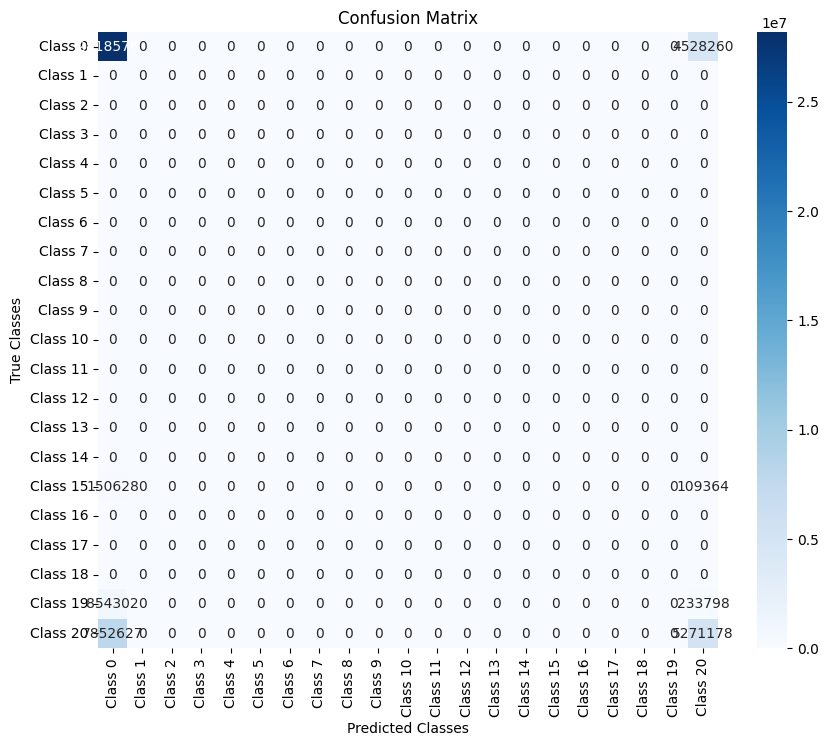

In [28]:
class_names = [f"Class {i}" for i in range(NUM_CLASSES)]
plot_confusion_matrix(all_y_true, all_y_pred, NUM_CLASSES, class_names)

In [24]:
mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_pixel_accuracy = np.mean(pixel_accuracy_scores)
std_pixel_accuracy = np.std(pixel_accuracy_scores)

mean_boundary_f1 = np.mean(boundary_f1_scores)
std_boundary_f1 = np.std(boundary_f1_scores)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("\nResultados Médios após Validação Cruzada (Média ± Desvio Padrão):")
print(f"Média IoU: {mean_iou:.4f} ± {std_iou:.4f}")
print(f"Média F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Média Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Média Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Média Pixel Accuracy: {mean_pixel_accuracy:.4f} ± {std_pixel_accuracy:.4f}")
print(f"Média Boundary F1 Score: {mean_boundary_f1:.4f} ± {std_boundary_f1:.4f}")
print(f"Média AUC: {mean_auc:.4f} ± {std_auc:.4f}")


Resultados Médios após Validação Cruzada (Média ± Desvio Padrão):
Média IoU: 0.2405 ± 0.0135
Média F1-Score: 0.6815 ± 0.0202
Média Precision: 0.7100 ± 0.0101
Média Recall: 0.7090 ± 0.0128
Média Pixel Accuracy: 0.7090 ± 0.0128
Média Boundary F1 Score: 0.4365 ± 0.0908
Média AUC: 0.5640 ± 0.0179
